semantic denoised hashing , which uses basic semantic hashing but denoises the input first then hashes for more robust prediction , model learns the important features more

imports and mnist dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Flatten,Reshape,BatchNormalization,GaussianNoise
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()
x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0
x_train=x_train.reshape(-1,28*28)
x_test=x_test.reshape(-1,28*28)

use kl divergence loss for sparse autoencoder so important features are learned and used. All training data is converted to its denoised form using this autoencoder.

In [ ]:
from tensorflow.keras.losses import MeanSquaredError

def kl_divergence(p,q):
  return p*tf.math.log(p/q)+(1-p)*tf.math.log((1-p)/(1-q))

class SparseAutoencoder(Model):
  def __init__(self,sparsity_target=0.1,sparsity_weight=0.2):
    super(SparseAutoencoder,self).__init__()
    self.sparsity_target=sparsity_target
    self.sparsity_weight=sparsity_weight
    self.hidden_layer=Dense(128,activation="sigmoid",name="hidden1")
    self.output_layer=Dense(28*28,activation="sigmoid",name="output")
  def call(self,inputs,training=False):
    hidden=self.hidden_layer(inputs)
    outputs=self.output_layer(hidden)
    return hidden,outputs
  def compute_losses(self,x):
    hidden,outputs=self(x)
    reconstruction_loss=tf.reduce_mean(tf.square(x-outputs))
    hidden_mean=tf.reduce_mean(hidden,axis=0)
    sparsity_loss=tf.reduce_sum(kl_divergence(self.sparsity_target,hidden_mean))
    total_loss=reconstruction_loss+self.sparsity_weight*sparsity_loss
    return total_loss

sparsity_target=0.1
sparsity_weight=0.2
autoencoder=SparseAutoencoder(sparsity_target,sparsity_weight)
optimizer=Adam(0.01)
epochs=10
batch_size=256

for epoch in range(epochs):
  for i in range(0,len(x_train),batch_size):
    x_batch=x_train[i:i+batch_size]
    with tf.GradientTape() as tape:
      loss=autoencoder.compute_losses(x_batch)
      grads=tape.gradient(loss,autoencoder.trainable_variables)
      optimizer.apply_gradients(zip(grads,autoencoder.trainable_variables))
  print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy():.4f}")

hidden,x_train=autoencoder(x_train)
x_train=x_train.numpy()
"""def plot_images(original,reconstructed,n_images=5):
    plt.figure(figsize=(10,4))
    for i in range(n_images):
      plt.subplot(2,n_images,i+1)
      plt.imshow(original[i].reshape(28,28),cmap='gray')
      plt.title("original")
      plt.axis("off")
      plt.subplot(2,n_images,n_images+i+1)
      plt.imshow(reconstructed[i].reshape(28,28),cmap='gray')
      plt.title("denoised")
      plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_images(x_test,reconstructed)"""

Epoch 1/10, Loss: 0.0687
Epoch 2/10, Loss: 0.0527
Epoch 3/10, Loss: 0.0417
Epoch 4/10, Loss: 0.0379
Epoch 5/10, Loss: 0.0534
Epoch 6/10, Loss: 0.0711
Epoch 7/10, Loss: 0.0781
Epoch 8/10, Loss: 0.0771
Epoch 9/10, Loss: 0.0751
Epoch 10/10, Loss: 0.0742


'def plot_images(original,reconstructed,n_images=5):\n    plt.figure(figsize=(10,4))\n    for i in range(n_images):\n      plt.subplot(2,n_images,i+1)\n      plt.imshow(original[i].reshape(28,28),cmap=\'gray\')\n      plt.title("original")\n      plt.axis("off")\n      plt.subplot(2,n_images,n_images+i+1)\n      plt.imshow(reconstructed[i].reshape(28,28),cmap=\'gray\')\n      plt.title("denoised")\n      plt.axis("off")\n    plt.tight_layout()\n    plt.show()\n\nplot_images(x_test,reconstructed)'

In [ ]:
"""def add_noise(images,noise_factor=0.2):
  noise=np.random.normal(loc=0.0,scale=noise_factor,size=images.shape)
  noisy_images=images+noise
  noisy_images=np.clip(noisy_images,0.0,1.0)
  return noisy_images

x_train=add_noise(x_train)
x_test=add_noise(x_test)"""

making another layered network that will later be used for semantic hashing. Gaussian noise to the internal layer may help.

In [ ]:
input_img=Input(shape=(28*28,))
x=Dense(256,activation='relu')(input_img)
x=BatchNormalization()(x)
x=Dense(128,activation='relu')(x)
x=BatchNormalization()(x)

#x=GaussianNoise(0.05)(x)
coding=Dense(30,activation='sigmoid',name='coding')(x)

x=Dense(128,activation='relu')(coding)
x=BatchNormalization()(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
output_img=Dense(28*28,activation='sigmoid')(x)

autoencoder=Model(input_img,output_img)
autoencoder.compile(optimizer='adam',loss='mse')
autoencoder.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ coding (Dense)                       │ (None, 30)                  │           3,870 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 784)                 │         201,488 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 479,278 (1.83 MB)

 Trainable params: 477,742 (1.82 MB)

 Non-trainable params: 1,536 (6.00 KB)

using the sparse autoencoder output as input

In [ ]:
autoencoder.fit(x_train,x_train,epochs=20,batch_size=256,validation_data=(x_test,x_test))

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.1099 - val_loss: 0.0454
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0032 - val_loss: 0.0273
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0241
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - val_loss: 0.0235
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.7374e-04 - val_loss: 0.0229
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.5025e-04 - val_loss: 0.0227
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7278e-04 - val_loss: 0.0223
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2089e-04 - val_loss: 0.0219
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.1561e-04 - val_loss: 0.0217
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5645e-04 - val_loss: 0.0216
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3640e-04 - val_loss: 0.0214
Epoch 12/20
235/235 ━━━

creating simple binary hashes

In [ ]:
encoder=Model(input_img,coding)
hashes=encoder.predict(x_test)
binary_hashes=(hashes>0.5).astype(int)
print("Sample Hashes:")
for i in range(5):
  print(binary_hashes[i])
print(len(binary_hashes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Sample Hashes:
[0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1]
[1 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1]
[0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0]
[1 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0]
[1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1]
10000


putting them and dictionary form, and visualising similar images based on how they were hashed

Hash: (0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1)


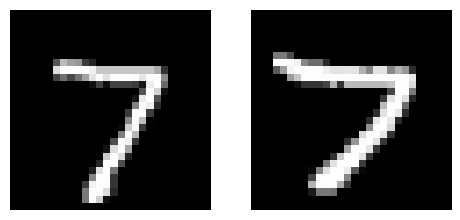

In [ ]:
from collections import defaultdict
hash_dict=defaultdict(list)
for i,h in enumerate(binary_hashes):
  hash_key=tuple(h)
  hash_dict[hash_key].append(i)

def plot_similar_images(indices,num_images=5):
  plt.figure(figsize=(15,5))
  for i,idx in enumerate(indices[:num_images]):
    plt.subplot(1,num_images,i+1)
    plt.imshow(x_test[idx].reshape(28,28),cmap='gray')
    plt.axis('off')

plt.show()

random_hash=next(iter(hash_dict))
print(f"Hash: {random_hash}")
plot_similar_images(hash_dict[random_hash])

gini score to see the model performance

In [ ]:
def gini_purity(groups,labels):
  total_purity=0
  for indices in groups.values():
    if len(indices)>1:
      label_counts=np.bincount(labels[indices])
      probabilities=label_counts/np.sum(label_counts)
      gini=1-np.sum(probabilities**2)
      total_purity+=gini*len(indices)
  return total_purity/len(labels)

gini_score=gini_purity(hash_dict,y_test)
print(f"Gini Purity: {gini_score:.4f}")

Gini Purity: 0.0322
